<a href="https://colab.research.google.com/github/erfanera/SlumImprovment/blob/main/Segmentation/BuildingSegmentation/FinalTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install segment-geospatial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 793.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu1

In [10]:
!pip install geopandas

In [16]:
!pip install contextily

In [11]:
import os
import requests
from PIL import Image
from io import BytesIO
import cv2
import numpy as np
import geopandas as gpd
from samgeo import SamGeo, tms_to_geotiff, get_basemaps

In [3]:

def readGitHubUrl(webAddress):
    img_url = webAddress

    # Get the image from the URL
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    # Convert the image to grayscale
    #bw_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    return img

In [4]:

image = readGitHubUrl("https://raw.github.com/erfanera/SlumImprovment/main/Images/SampleSpliteSatellite.png")

In [5]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    sam_kwargs=None,
)

Model checkpoint for vit_h not found.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.56G/2.56G [00:28<00:00, 90.1MB/s]


In [6]:
mask = "segment.tif"
sam.generate(
    "https://raw.github.com/erfanera/SlumImprovment/main/Images/SampleSpliteSatellite.png", mask, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255
)

Downloading...
From: https://raw.github.com/erfanera/SlumImprovment/main/Images/SampleSpliteSatellite.png
To: /content/SampleSpliteSatellite.png
100%|██████████| 11.6M/11.6M [00:00<00:00, 27.0MB/s]
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(
100%|██████████| 49/49 [06:20<00:00,  7.76s/it]


In [7]:
vector = "segment.gpkg"
sam.tiff_to_gpkg(mask, vector, simplify_tolerance=None)
shapefile = "segment.shp"
sam.tiff_to_vector(mask, shapefile)

In [22]:
gdf = gpd.read_file(shapefile)
editedGraph = '/content/your_modified_shapefile.shp'
from shapely.geometry import Polygon

def close_polygon(polygon):
    if not polygon.is_empty and not polygon.is_closed:
        # If the polygon is not closed, create a new polygon that is closed
        return Polygon(list(polygon.exterior.coords) + [polygon.exterior.coords[0]])
    return polygon

# Apply the function to close polygons if they are not closed
gdf['geometry'] = gdf['geometry'].apply(close_polygon)
# Check if all polygons are now closed
all(gdf['geometry'].apply(lambda x: x.is_closed))

# Save the modified GeoDataFrame to a new Shapefile
gdf.to_file(editedGraph)



In [32]:
# Calculate area of each polygon
gdf['area'] = gdf['geometry'].area

# Sort polygons by area in descending order
gdf_sorted = gdf.sort_values(by='area', ascending=False)

gdf_filtered = gdf_sorted.iloc[10:]

In [26]:
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
# image.add_vector(vector, layer_name="Vector", style=style)
# image
mask

'segment.tif'

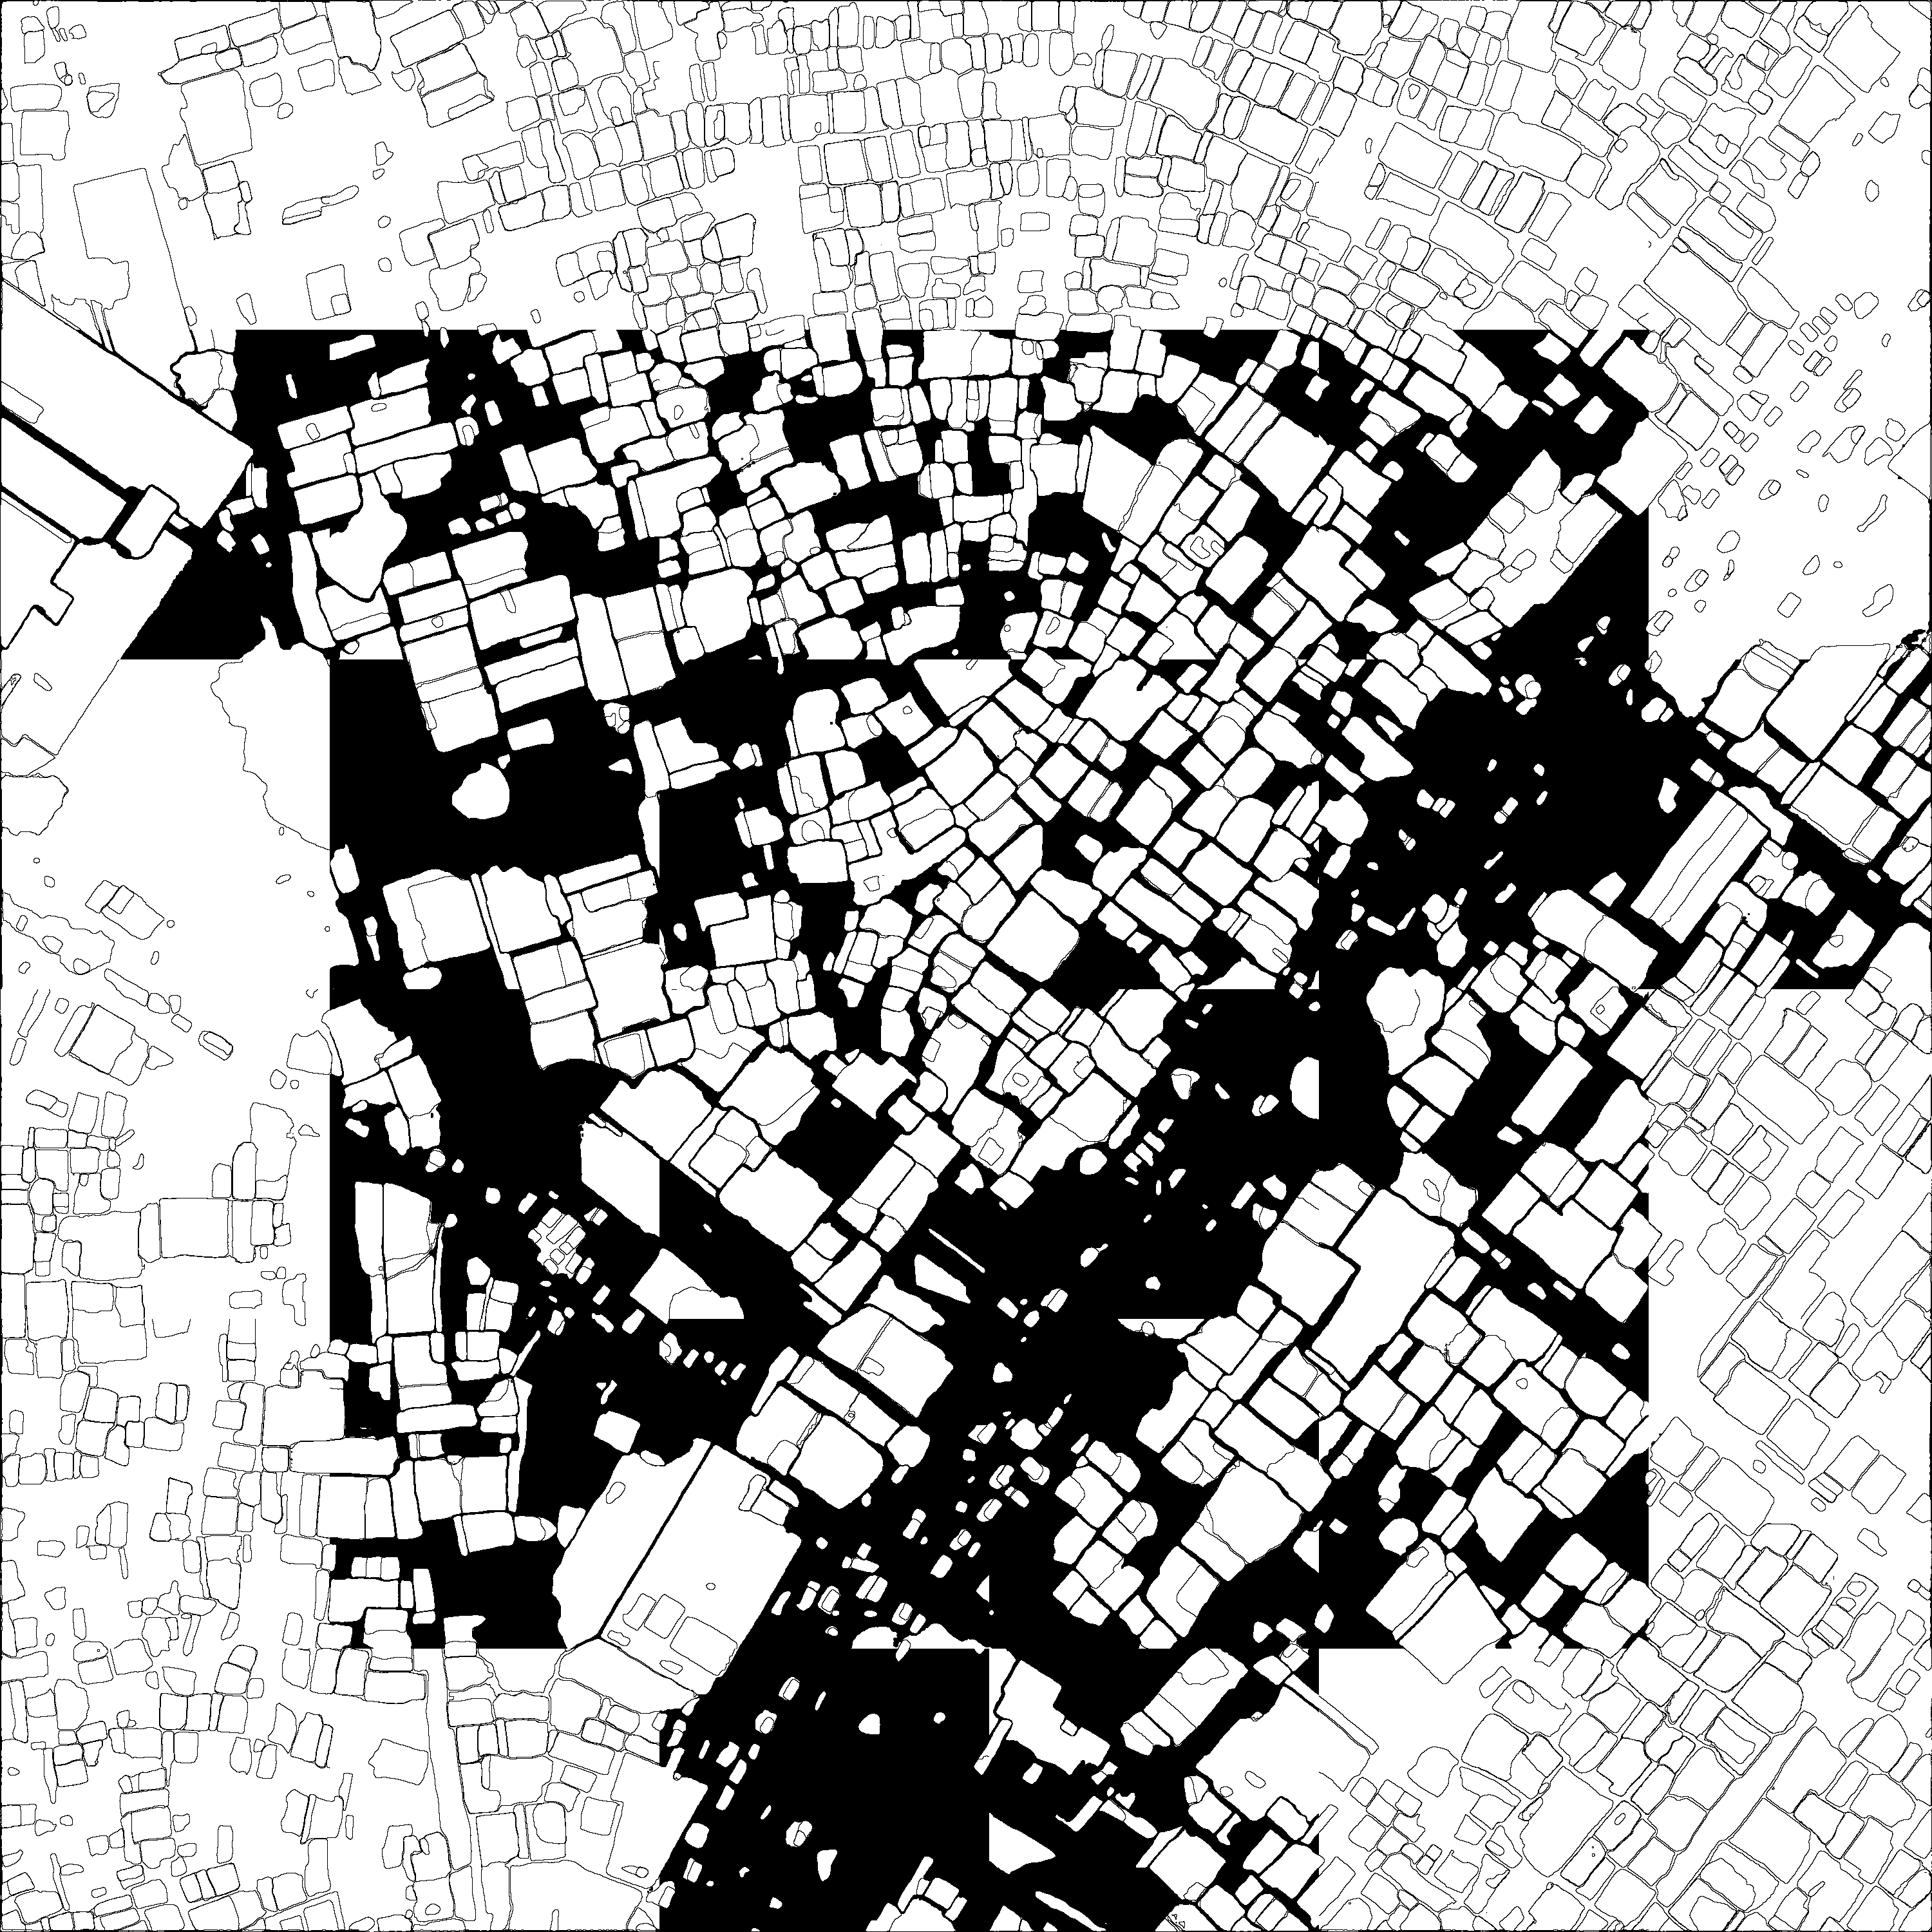

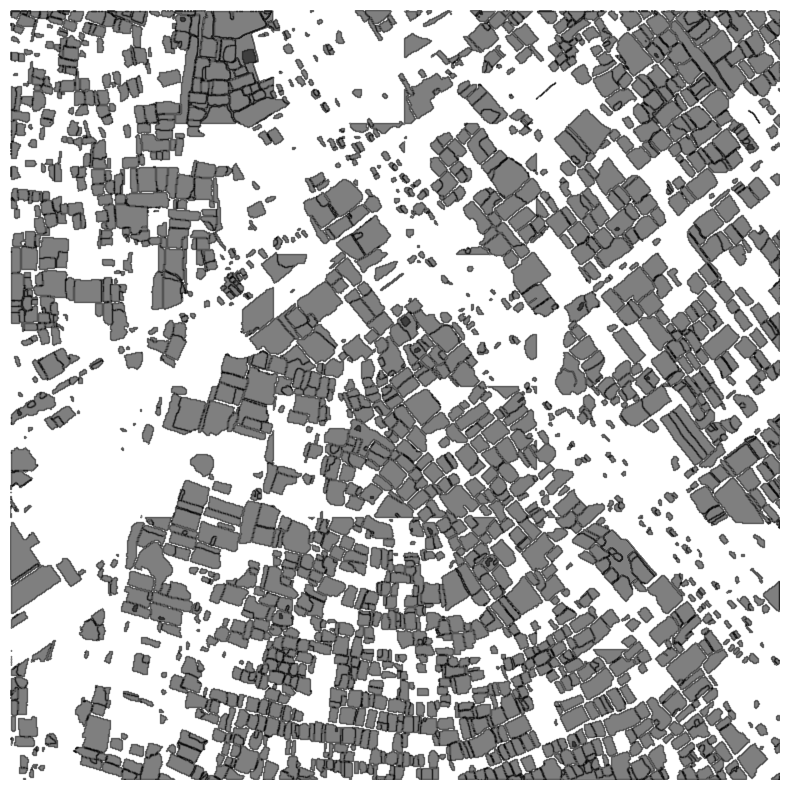

In [33]:
import matplotlib.pyplot as plt
import contextily as ctx

# Convert CRS to EPSG:3857 for contextily compatibility, if necessary
# if gdf.crs != "EPSG:3857":
#     gdf = gdf.to_crs(epsg=3857)

# Plotting the shapefile
fig, ax = plt.subplots(figsize=(10, 10))  # You can adjust the size as needed
gdf_filtered.plot(ax=ax, alpha=0.5, edgecolor='k', facecolor = 'k')  # Adjust appearance as needed

# Add a basemap
#ctx.add_basemap(ax, crs=gdf.crs.to_string())

# Adjust the plot limits to the bounds of your polygons for better fitting
ax.set_xlim([gdf.total_bounds[0], gdf.total_bounds[2]])
ax.set_ylim([gdf.total_bounds[1], gdf.total_bounds[3]])

# Remove axes clutter
ax.set_axis_off()

# Show the plot
plt.show()
